In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    sub_dirs = sorted(os.listdir(image_dir))
    for sub_dir in sub_dirs:
        sub_image_dir = os.path.join(image_dir, sub_dir)
        sub_mask_dir = os.path.join(mask_dir, sub_dir)
        image_filenames = sorted(os.listdir(sub_image_dir))
        mask_filenames = sorted(os.listdir(sub_mask_dir))
        assert len(image_filenames) == len(mask_filenames), f"Mismatch in number of images and masks in {sub_dir}."
        for img_filename, mask_filename in zip(image_filenames, mask_filenames):
            img_path = os.path.join(sub_image_dir, img_filename)
            mask_path = os.path.join(sub_mask_dir, mask_filename)

            img = load_img(img_path, target_size=target_size)
            mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')

            img_array = img_to_array(img) / 255.0  # Normalize image
            mask_array = img_to_array(mask).astype(np.int32).squeeze()

            # Convert mask to binary (foreground=1, background=0)
            mask_array = (mask_array > 0).astype(np.int32)

            images.append(img_array)
            masks.append(mask_array)

    images = np.array(images)
    masks = np.array(masks)

    # Add channel dimension to masks (required for binary segmentation)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks


image_dir = '/kaggle/input/original-images/Original'  # Path to original images
mask_dir = '/kaggle/input/mask-images/mask'      # Path to mask images

X, y = load_and_preprocess_data(image_dir, mask_dir)
print(f"Total loaded images: {len(X)}")
print(f"Total loaded masks: {len(y)}")

# Split data into training and validation sets
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Total loaded images: 2152
Total loaded masks: 2152
Training set size: 1506
Validation set size: 323
Test set size: 323


In [ ]:
##### Load the unet Model #####

In [3]:
import pickle

model_path = "/kaggle/input/unet/other/default/1/model_unet.pkl"

# Load the pickled model
with open(model_path, 'rb') as file:
    unet_model = pickle.load(file)

print("Model loaded successfully!")


Model loaded successfully!


In [4]:
print("Evaluating the model...")
loss, accuracy = unet_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 667ms/step - accuracy: 0.8898 - loss: 0.2796
Test Loss: 0.28477251529693604
Test Accuracy: 0.8911954760551453


In [5]:
val_loss, val_accuracy = unet_model.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.8939 - loss: 0.2680
Val Loss: 0.26115262508392334
Val Accuracy: 0.8954388499259949


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step
Classification Report:
                precision    recall  f1-score   support

Background (0)       0.94      0.92      0.93  16522363
Foreground (1)       0.74      0.78      0.76   4645765

      accuracy                           0.89  21168128
     macro avg       0.84      0.85      0.84  21168128
  weighted avg       0.89      0.89      0.89  21168128

Mean IoU: 0.6123
Dice Coefficient: 0.7595
Pixel Accuracy: 0.8912
Testing Accuracy: 89.12%


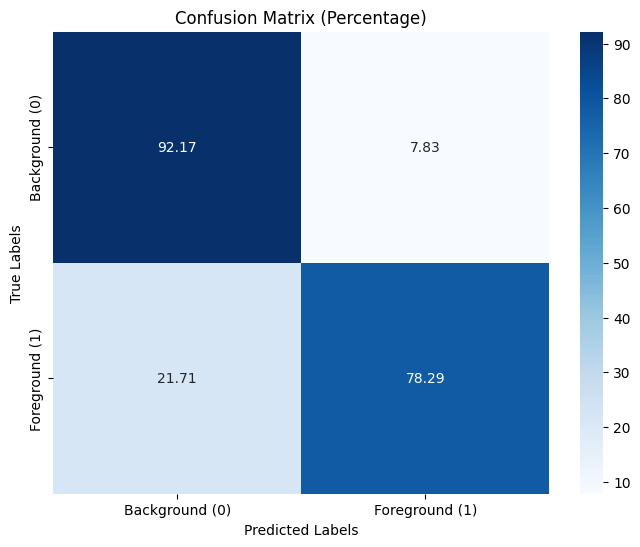

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    predictions = model.predict(test_images)
    predictions = np.squeeze(predictions, axis=-1)  # Ensure correct shape

    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    print("Classification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    iou = mean_iou(test_masks_binary_flat, predicted_masks_flat)
    dice = dice_coefficient(test_masks_binary_flat, predicted_masks_flat)
    accuracy = pixel_accuracy(test_masks_binary_flat, predicted_masks_flat)
    correct_predictions = np.sum(test_masks_binary_flat == predicted_masks_flat)
    testing_accuracy = (correct_predictions / test_masks_binary_flat.size) * 100

    print(f"Mean IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Background (0)", "Foreground (1)"],
                yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
compute_metrics_and_plot_confusion_matrix(unet_model, X_test, y_test)

In [ ]:
###### Testing on Images #######

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


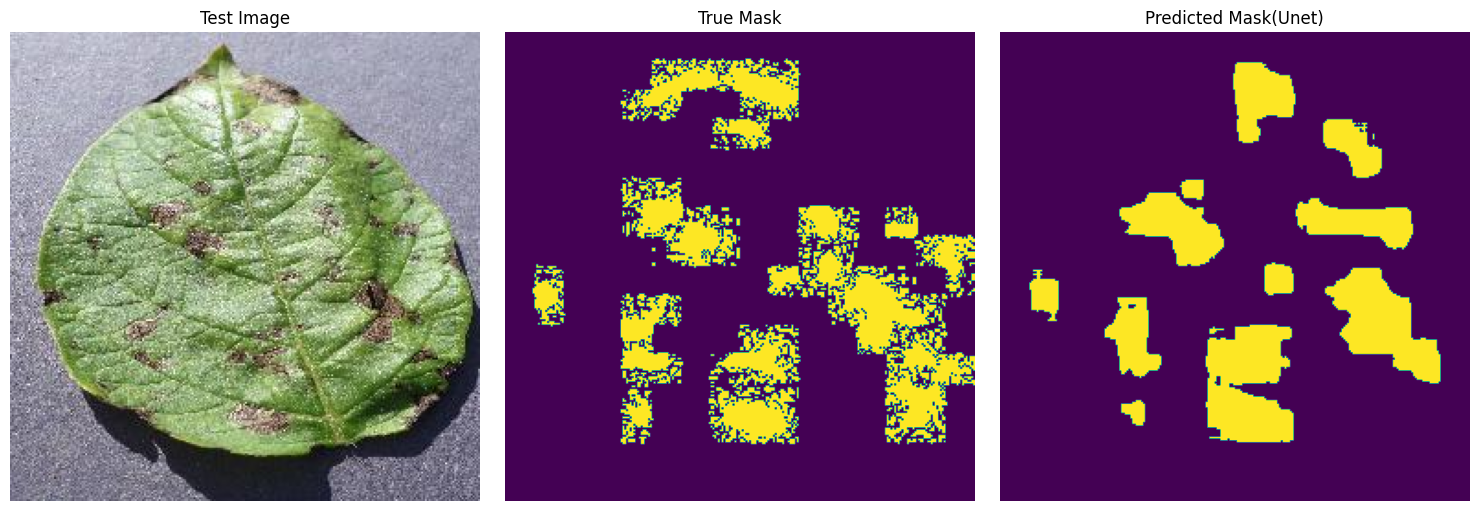

In [28]:
import random

def test_random_image(model, X_test, y_test):
    # Select a random index
    #random_index = random.randint(0, len(X_test) - 1)
    random_index = 35
    
    # Get the test image and true mask
    test_image = X_test[random_index]
    true_mask = y_test[random_index]
    
    # Model prediction (add batch dimension as the model expects it)
    predicted_mask = model.predict(test_image[np.newaxis, ...])[0]
    
    # Threshold the predicted mask (binary segmentation: threshold at 0.5)
    predicted_mask = (predicted_mask > 0.5).astype(np.int32).squeeze()
    
    # Visualize the test image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("True Mask")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask(Unet)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Test a random image
test_random_image(unet_model, X_test, y_test)

In [ ]:
##### Load Deeplav Model #####

In [15]:
import pickle

model_path = "/kaggle/input/deeplab/other/default/1/model_deeplab.pkl"

# Load the pickled model
with open(model_path, 'rb') as file:
    deeplab_model = pickle.load(file)

print("Model loaded successfully!")

Model loaded successfully!


In [8]:
print("Evaluating the model...")
loss, accuracy = deeplab_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.8796 - loss: 0.2892
Test Loss: 0.28854307532310486
Test Accuracy: 0.8796191811561584


In [9]:
val_loss, val_accuracy = deeplab_model.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8843 - loss: 0.2817
Val Loss: 0.2800488770008087
Val Accuracy: 0.8859602808952332


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
Classification Report:
                precision    recall  f1-score   support

Background (0)       0.92      0.92      0.92  16522363
Foreground (1)       0.72      0.73      0.73   4645765

      accuracy                           0.88  21168128
     macro avg       0.82      0.83      0.82  21168128
  weighted avg       0.88      0.88      0.88  21168128

Mean IoU: 0.5707
Dice Coefficient: 0.7267
Pixel Accuracy: 0.8796
Testing Accuracy: 87.96%


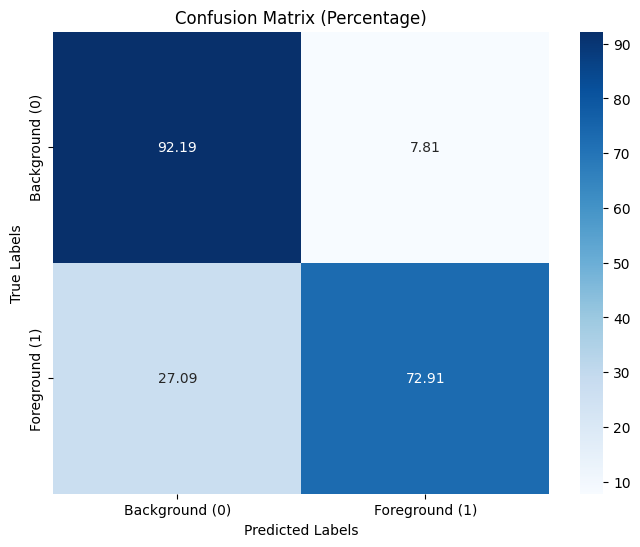

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    predictions = model.predict(test_images)
    predictions = np.squeeze(predictions, axis=-1)  # Ensure correct shape

    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    print("Classification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    iou = mean_iou(test_masks_binary_flat, predicted_masks_flat)
    dice = dice_coefficient(test_masks_binary_flat, predicted_masks_flat)
    accuracy = pixel_accuracy(test_masks_binary_flat, predicted_masks_flat)
    correct_predictions = np.sum(test_masks_binary_flat == predicted_masks_flat)
    testing_accuracy = (correct_predictions / test_masks_binary_flat.size) * 100

    print(f"Mean IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Background (0)", "Foreground (1)"],
                yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
compute_metrics_and_plot_confusion_matrix(deeplab_model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


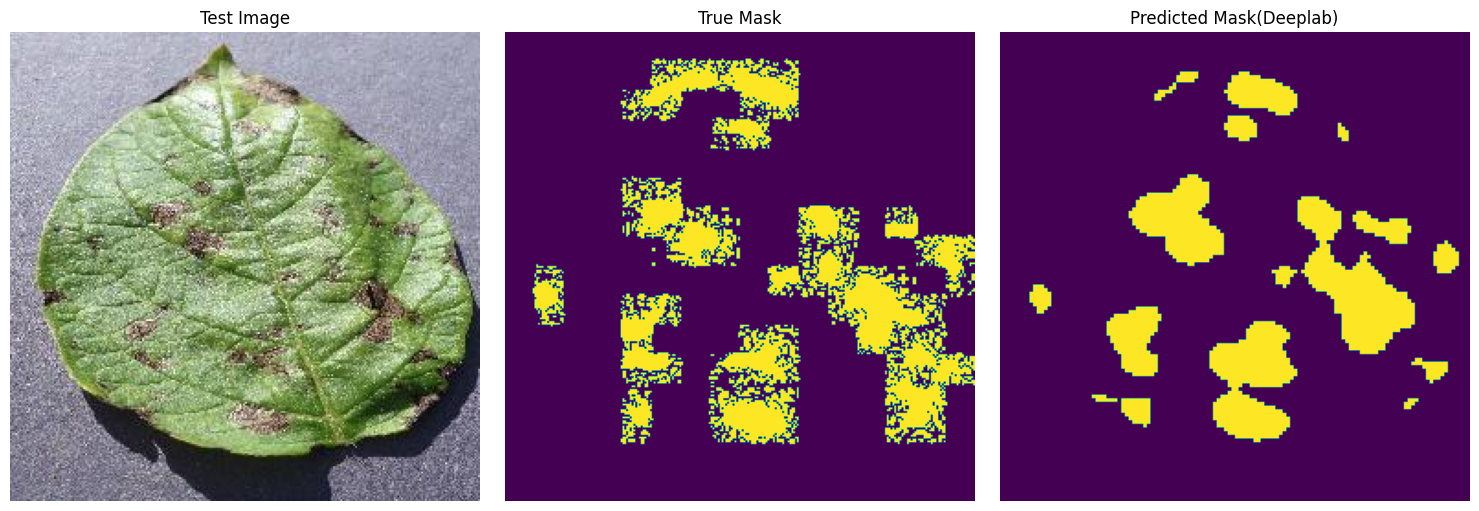

In [27]:
import random

def test_random_image(model, X_test, y_test):
    # Select a random index
    #random_index = random.randint(0, len(X_test) - 1)
    random_index = 35
    
    # Get the test image and true mask
    test_image = X_test[random_index]
    true_mask = y_test[random_index]
    
    # Model prediction (add batch dimension as the model expects it)
    predicted_mask = model.predict(test_image[np.newaxis, ...])[0]
    
    # Threshold the predicted mask (binary segmentation: threshold at 0.5)
    predicted_mask = (predicted_mask > 0.5).astype(np.int32).squeeze()
    
    # Visualize the test image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("True Mask")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask(Deeplab)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Test a random image
test_random_image(deeplab_model, X_test, y_test)

In [ ]:
#### Load fcn model #####

In [29]:
import pickle

model_path = "/kaggle/input/fcn/other/default/1/model_fcn.pkl"

# Load the pickled model
with open(model_path, 'rb') as file:
    fcn_model = pickle.load(file)

print("Model loaded successfully!")

Model loaded successfully!


In [12]:
print("Evaluating the model...")
loss, accuracy = fcn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.9024 - loss: 0.2252
Test Loss: 0.22729820013046265
Test Accuracy: 0.9034359455108643


In [13]:
val_loss, val_accuracy = fcn_model.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9008 - loss: 0.2295
Val Loss: 0.22239281237125397
Val Accuracy: 0.9035928249359131


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step
Classification Report:
                precision    recall  f1-score   support

Background (0)       0.93      0.95      0.94  16522363
Foreground (1)       0.80      0.75      0.77   4645765

      accuracy                           0.90  21168128
     macro avg       0.86      0.85      0.86  21168128
  weighted avg       0.90      0.90      0.90  21168128

Mean IoU: 0.6302
Dice Coefficient: 0.7731
Pixel Accuracy: 0.9034
Testing Accuracy: 90.34%


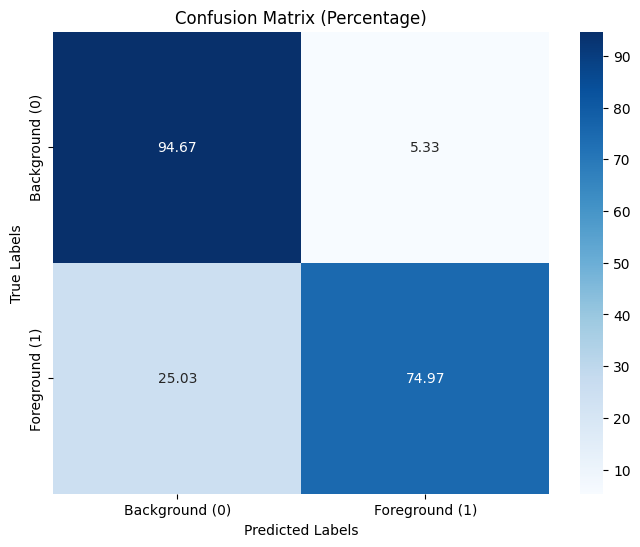

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    predictions = model.predict(test_images)
    predictions = np.squeeze(predictions, axis=-1)  # Ensure correct shape

    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    print("Classification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    iou = mean_iou(test_masks_binary_flat, predicted_masks_flat)
    dice = dice_coefficient(test_masks_binary_flat, predicted_masks_flat)
    accuracy = pixel_accuracy(test_masks_binary_flat, predicted_masks_flat)
    correct_predictions = np.sum(test_masks_binary_flat == predicted_masks_flat)
    testing_accuracy = (correct_predictions / test_masks_binary_flat.size) * 100

    print(f"Mean IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Background (0)", "Foreground (1)"],
                yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
compute_metrics_and_plot_confusion_matrix(fcn_model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


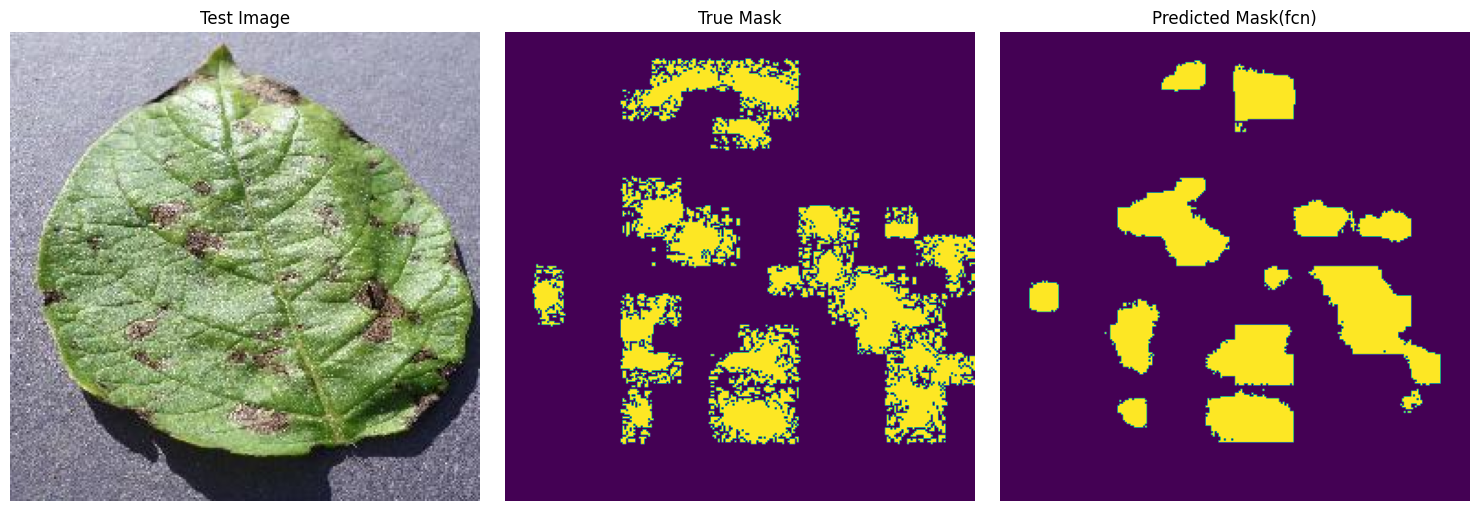

In [33]:
import random

def test_random_image(model, X_test, y_test):
    # Select a random index
    #random_index = random.randint(0, len(X_test) - 1)
    random_index = 35
    
    # Get the test image and true mask
    test_image = X_test[random_index]
    true_mask = y_test[random_index]
    
    # Model prediction (add batch dimension as the model expects it)
    predicted_mask = model.predict(test_image[np.newaxis, ...])[0]
    
    # Threshold the predicted mask (binary segmentation: threshold at 0.5)
    predicted_mask = (predicted_mask > 0.5).astype(np.int32).squeeze()
    
    # Visualize the test image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("True Mask")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask(fcn)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Test a random image
test_random_image(fcn_model, X_test, y_test)

In [ ]:
### Load Segnet Model

In [31]:
import pickle

model_path = "/kaggle/input/segnet/other/default/1/model_segnet.pkl"

# Load the pickled model
with open(model_path, 'rb') as file:
    segnet_model = pickle.load(file)

print("Model loaded successfully!")

Model loaded successfully!


In [16]:
print("Evaluating the model...")
loss, accuracy = segnet_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.8894 - loss: 0.3252
Test Loss: 0.3277137279510498
Test Accuracy: 0.8923126459121704


In [17]:
val_loss, val_accuracy = segnet_model.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.8918 - loss: 0.3239
Val Loss: 0.32035359740257263
Val Accuracy: 0.8926283717155457


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step
Classification Report:
                precision    recall  f1-score   support

Background (0)       0.92      0.94      0.93  16522363
Foreground (1)       0.77      0.72      0.75   4645765

      accuracy                           0.89  21168128
     macro avg       0.85      0.83      0.84  21168128
  weighted avg       0.89      0.89      0.89  21168128

Mean IoU: 0.5957
Dice Coefficient: 0.7466
Pixel Accuracy: 0.8923
Testing Accuracy: 89.23%


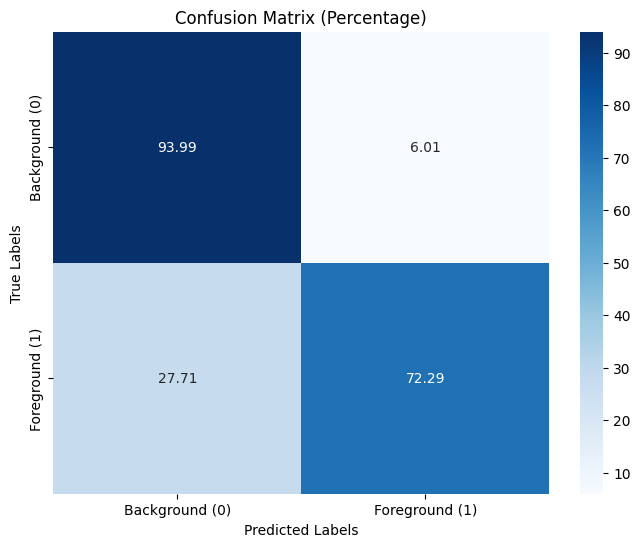

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    predictions = model.predict(test_images)
    predictions = np.squeeze(predictions, axis=-1)  # Ensure correct shape

    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    print("Classification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    iou = mean_iou(test_masks_binary_flat, predicted_masks_flat)
    dice = dice_coefficient(test_masks_binary_flat, predicted_masks_flat)
    accuracy = pixel_accuracy(test_masks_binary_flat, predicted_masks_flat)
    correct_predictions = np.sum(test_masks_binary_flat == predicted_masks_flat)
    testing_accuracy = (correct_predictions / test_masks_binary_flat.size) * 100

    print(f"Mean IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Background (0)", "Foreground (1)"],
                yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
compute_metrics_and_plot_confusion_matrix(segnet_model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


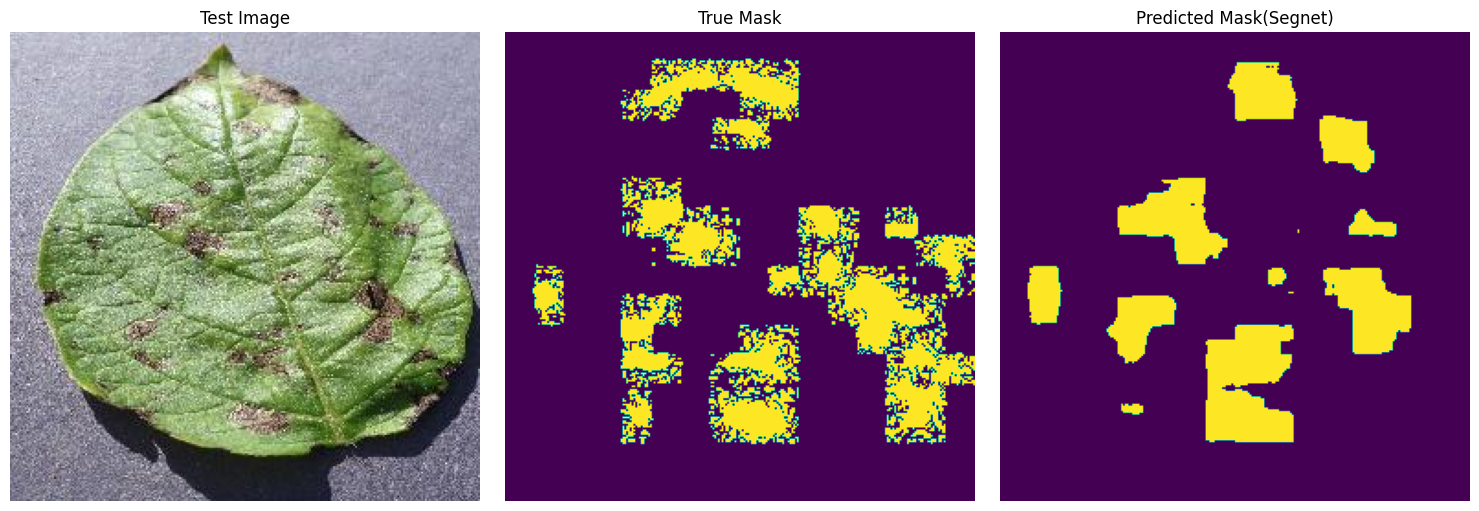

In [32]:
import random

def test_random_image(model, X_test, y_test):
    # Select a random index
    #random_index = random.randint(0, len(X_test) - 1)
    random_index = 35
    
    # Get the test image and true mask
    test_image = X_test[random_index]
    true_mask = y_test[random_index]
    
    # Model prediction (add batch dimension as the model expects it)
    predicted_mask = model.predict(test_image[np.newaxis, ...])[0]
    
    # Threshold the predicted mask (binary segmentation: threshold at 0.5)
    predicted_mask = (predicted_mask > 0.5).astype(np.int32).squeeze()
    
    # Visualize the test image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("True Mask")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask(Segnet)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Test a random image
test_random_image(segnet_model, X_test, y_test)